# Retrieval Augmented Generation (RAG) with LangChain 🦜🔗

Last update: 25.05.2025

<img src="./assets/agent_semantic-search.png" width="800">

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain import hub
from langchain.prompts import PromptTemplate

from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from IPython.display import Image, display

from dotenv import load_dotenv
load_dotenv()

import warnings
from langsmith.utils import LangSmithMissingAPIKeyWarning
warnings.filterwarnings("ignore", category=LangSmithMissingAPIKeyWarning)



## Load

LangChain’s `Document` is a data structure for handling text chunks. It typically represents a portion of a larger document and includes the following attributes:

- `id`: optional unique identifier
- `metadata`: a dictionary with source info or context
- `page_content`: the text content itself (required)
- `type`: new addition for the document type, e.g. Document or TextChunk


LangChain supports various [PDF loaders](https://python.langchain.com/docs/integrations/document_loaders/#pdfs), ranging from basic text extractors to advanced tools with OCR and layout analysis, allowing users to choose based on their specific needs:

- `PyPDFLoader`: best all-around for academic or structured PDFs. Great for research papers, reports, and text-based documents.
- `Unstructured`: best for scanned PDFs (with OCR support). Great for invoices, scanned forms, mixed-content files.
- `MathPix`: extracts math formulas, LaTeX, and figures well. Ideal for scientific articles, research papers with math.
- `PDFPlumber`: strong at extracting tables and structured data. Use when you care about exact layout or tabular info.

[PyPDFLoader](https://python.langchain.com/docs/integrations/document_loaders/pypdfloader/) reads text from PDFs and returns one Document per page, with the text in `page_content`. When creating Document objects, PyPDFLoader typically tries to extract the human-readable `page_label` if it exists; otherwise, it falls back to a 1-based page number (i.e., index + 1).

In [4]:
file_path = "./data/input/BILLS-119hr1892ih.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(f"Total pages: {len(docs)}")
print(f"Document keys: {docs[0].model_dump().keys()}") 
print(f"Current page: {docs[0].metadata['page_label']}") 
print(f"Total characters on page {docs[0].metadata['page_label']}: {len(docs[0].page_content)}")
print(f"First 280 characters {docs[0].page_content[:280]}")


Total pages: 11
Document keys: dict_keys(['id', 'metadata', 'page_content', 'type'])
Current page: 1
Total characters on page 1: 1221
First 280 characters I 
119TH CONGRESS 
1ST SESSION H. R. 1892 
To direct the Secretary of Transportation to establish a Wireless Electric 
Vehicle Charging Grant Program, and for other purposes. 
IN THE HOUSE OF REPRESENTATIVES 
MARCH 5, 2025 
Ms. S TEVENS (for herself, Ms. B ARRAGA´N, Mrs. D INGELL


## Split

To improve retrieval and question answering, PDF pages can be split into smaller chunks using text splitters. LangChain recommends using `RecursiveCharacterTextSplitter` to divide text into chunks with overlap, preserving context. 

In [28]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, 
    chunk_overlap=200,
    #separators=[r"^\s*SEC\.\s*\d+\."],
    separators=[r"(?=SEC\.)"],
    is_separator_regex=True
)
all_splits = text_splitter.split_documents(docs)

print(f"Split the pdf into {len(all_splits)} sub-documents.")

Split the pdf into 16 sub-documents.


In [29]:
for i in range(len(all_splits)):
    print(all_splits[i].page_content)
    print("-------------------------")


I 
119TH CONGRESS 
1ST SESSION H. R. 1892 
To direct the Secretary of Transportation to establish a Wireless Electric 
Vehicle Charging Grant Program, and for other purposes. 
IN THE HOUSE OF REPRESENTATIVES 
MARCH 5, 2025 
Ms. S TEVENS (for herself, Ms. B ARRAGA´N, Mrs. D INGELL, and Ms. T ITUS) 
introduced the following bill; which was referred to the Committee on En-
ergy and Commerce, and in addition to the Committee on Transportation 
and Infrastructure, for a period to be subsequently determined by the 
Speaker, in each case for consideration of such provisions as fall within 
the jurisdiction of the committee concerned 
A BILL 
To direct the Secretary of Transportation to establish a 
Wireless Electric Vehicle Charging Grant Program, and 
for other purposes. 
Be it enacted by the Senate and House of Representa-1
tives of the United States of America in Congress assembled, 2
SECTION 1. SHORT TITLE. 3
This Act may be cited as the ‘‘Wireless Electric Vehi-4
cle Charging Grant Progr

## Embed

LangChain supports [embeddings from many providers](https://python.langchain.com/docs/integrations/text_embedding/) like OpenAI, Google, Hugging Face, Llama, NVIDIA, and others.

In [33]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
print(embeddings.model)

vector = embeddings.embed_query("Hi!")
print("Vector length:", len(vector))
print(vector[:3])

models/embedding-001
Vector length: 768
[0.010295657441020012, -0.02703550085425377, -0.01325113233178854]


## Store

LangChain’s `VectorStore` lets you add and search text or documents using vector similarity. It works with embedding models to convert text into numeric vectors.

LangChain supports many vector stores—some are cloud-based (e.g. AstraDB), some run on local servers (e.g. Chroma), and others run **in-memory**, meaning they store data temporarily in your computer's RAM, ideal for quick tests or small workloads.

In [34]:
vector_store = InMemoryVectorStore(embeddings)
ids = vector_store.add_documents(documents=all_splits)
print(f"Number of IDs: {len(ids)}")
print(f"Sample IDs: {ids[0]}, {ids[3]}")

Number of IDs: 16
Sample IDs: d34a4415-e529-4c0c-9a03-299500f70763, b74ceafb-dcac-4517-9c38-7d2b0361c133


## Retrieve

<img src="./assets/agent_rag-simple.png" width="800">

Once a `VectorStore` has documents, you can query it in various ways:
- by similarity or maximum marginal relevance (MMR),
- sync or async, 
- using text or vectors, 
- with or without similarity scores.

In [75]:
rag_prompt = hub.pull("rlm/rag-prompt")
print("-----\nRAG Prompt:\n", rag_prompt.messages[0].prompt.template)

custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""You are a retrieval-augmented assistant. Answer the question using only the information provided in the context. Quote or copy the exact relevant text from the context, cleaning PDF extraction artifacts, such as line numbers, if necessary. If the answer is not present, reply "Not in context."
Question: {question}
Context: {context}
Answer:"""
)
print("-----\nCustom Prompt:\n", custom_prompt.template)



-----
RAG Prompt:
 You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
-----
Custom Prompt:
 You are a retrieval-augmented assistant. Answer the question using only the information provided in the context. Quote or copy the exact relevant text from the context, cleaning PDF extraction artifacts, such as line numbers, if necessary. If the answer is not present, reply "Not in context."
Question: {question}
Context: {context}
Answer:


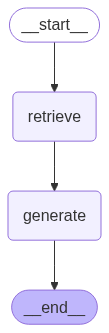

In [76]:
llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"], k=10)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png(
    background_color="transparent",
    output_file_path="./data/output/langgraph.png"
)))

In [77]:
result = graph.invoke({"question": """What is the maximum Federal share percentage 
                       allowed for a grant under the 
                       Wireless Electric Vehicle Charging Grant Program?"""})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='6802cc30-3765-4382-afb3-a7b1b9444ced', metadata={'producer': 'Acrobat Distiller 24.0 (Windows); modified using iText® Core 7.2.3 (production version) ©2000-2022 iText Group NV, Government Publishing Office', 'creator': 'U.S. Gov. Printing Office -- G.S.D.D.', 'creationdate': '2025-03-19T21:00:42-04:00', 'moddate': '2025-03-20T02:50:22+00:00', 'title': '', 'source': './data/input/BILLS-119hr1892ih.pdf', 'total_pages': 11, 'page': 6, 'page_label': '7'}, page_content='SEC. 7. PROGRAM REQUIREMENTS. 11\n(a) P RIORITY.—In awarding the grants under the 12\nProgram, the Secretary shall prioritize projects that— 13\n(1) focus on non-disruptive designs that are 14\ncompatible with existing infrastructure and bene-15\nficial to the public, including for low income, under-16\nserved, or disadvantaged communities; 17\n(2) focus on cost-effective, energy-efficient, and 18\nenvironmentally sustainable technologies for public 19\nuse; 20\n(3) focus on compatibility with the enti

In [78]:
# Questions to test search accuracy
questions = [
    "What is the maximum grant amount (in dollars) that an eligible entity can receive under the Wireless Electric Vehicle Charging Grant Program Act of 2025?",
    "What is the maximum Federal share percentage allowed for a grant under this Program?",
    "What total amount is authorized to be appropriated for the Program (in dollars)?",
    "According to the bill, what percentage of greenhouse gas emissions did the transportation sector account for as of 2019?",
    "Under the 'Buy America' requirement, which section of Title 49, United States Code, must grant recipients comply with?"
]

for i, question in enumerate(questions, 1):
    result = graph.invoke({"question": question})
    print(f"Q{i}: {question}")
    print(f"Answer: {result['answer']}\n")

Q1: What is the maximum grant amount (in dollars) that an eligible entity can receive under the Wireless Electric Vehicle Charging Grant Program Act of 2025?
Answer: "The amount of a grant awarded to an eligible entity under the Program may not exceed $25,000,000."

Q2: What is the maximum Federal share percentage allowed for a grant under this Program?
Answer: "The Federal share of a grant awarded under the Program may not exceed 80 percent of total cost of the project."

Q3: What total amount is authorized to be appropriated for the Program (in dollars)?
Answer: "There is authorized to be appropriated $250,000,000 to carry out this Act, to remain available until expended."

Q4: According to the bill, what percentage of greenhouse gas emissions did the transportation sector account for as of 2019?
Answer: "As of 2019, the transportation sector accounts for 29 percent of all greenhouse gas emissions, which is the most of any sector."

Q5: Under the 'Buy America' requirement, which sect

# References:

- LangChain. Build a Retrieval Augmented Generation (RAG) App: Part 1. https://python.langchain.com/docs/tutorials/rag/
- LangChain. Build a semantic search engine. https://python.langchain.com/docs/tutorials/retrievers/

